<a href="https://colab.research.google.com/github/musaadamu/nlpprojects/blob/main/english_question_images3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision transformers pandas gradio


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gradio as gr
import os


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/nlp_colab

/content/drive/MyDrive/nlp_colab


In [5]:
from sklearn.preprocessing import LabelEncoder
# Load the data
data = pd.read_csv('data2.csv')  # Path to your CSV file

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def load_image(image_id, image_folder='images'):
    image_path = os.path.join(image_folder, f"{image_id}.png")  # Adjust extension if needed
    if not os.path.exists(image_path):
        print(f"FileNotFoundError: Image {image_path} not found.")
        raise FileNotFoundError(f"Image {image_path} not found.")
    image = Image.open(image_path).convert("RGB")
    return transform(image)

# Initialize lists to store images, questions, and labels
images = []
questions = []
labels = []

# Create label mapping
unique_labels = data['answer'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
label_encoder = LabelEncoder()
label_encoder.fit(data['answer'])

# Load images, questions, and labels
for idx, row in data.iterrows():
    try:
        # Load and transform the image
        image_tensor = load_image(row['image_id'], image_folder='images')
        images.append(image_tensor)

        # Concatenate questions
        combined_question = " ".join([row['englishquestion'], row['hausaquestion'], row['englishhausaquestion']])
        questions.append(combined_question)

        labels.append(label_map[row['answer']])
    except FileNotFoundError as e:
        print(e)
        continue

# Tokenize questions
question_tokens = tokenizer(questions, padding=True, truncation=True, return_tensors="pt")
print("Questions tokenized shape:", question_tokens['input_ids'].shape)

# Convert labels to a tensor
label_tensor = torch.tensor(labels)
print("Labels tensor shape:", label_tensor.shape)

# Stack images into a single tensor
image_stack = torch.stack(images)
print("Images stacked shape:", image_stack.shape)

print("Data preparation successful.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Questions tokenized shape: torch.Size([500, 75])
Labels tensor shape: torch.Size([500])
Images stacked shape: torch.Size([500, 3, 224, 224])
Data preparation successful.


In [6]:
from torch.utils.data import DataLoader, Dataset, random_split
class CustomDataset(Dataset):
    def __init__(self, question_tokens, images, labels):
        self.input_ids = question_tokens['input_ids']
        self.attention_mask = question_tokens['attention_mask']
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.images[idx], self.labels[idx]

# Create dataset
dataset = CustomDataset(question_tokens, image_stack, label_tensor)

# Split dataset into train and eval sets
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class BertCNNModel(nn.Module):
    def __init__(self):
        super(BertCNNModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 112 * 112 + 768, 512)
        self.fc2 = nn.Linear(512, len(label_map))

    def forward(self, input_ids, attention_mask, images):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled_output = bert_outputs.pooler_output
        x = self.pool(F.relu(self.conv1(images)))
        x = x.view(x.size(0), -1)
        combined = torch.cat((x, bert_pooled_output), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertCNNModel().to(device)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [9]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score

# Initialize loss function and optimizer
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(2):  # Adjust number of epochs as needed
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, images, labels = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask, images)

        # Compute loss
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

    # Evaluation
    model.eval()
    eval_preds = []
    eval_labels = []
    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids, attention_mask, images, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)
            eval_preds.extend(preds.cpu().numpy())
            eval_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(eval_labels, eval_preds)
    print(f"Epoch {epoch+1}, Evaluation Accuracy: {accuracy}")


Epoch 1, Loss: 4.7696371221542355
Epoch 1, Evaluation Accuracy: 0.02
Epoch 2, Loss: 4.356561050415039
Epoch 2, Evaluation Accuracy: 0.01


In [10]:
def predict(question1, question2, question3, image):
    model.eval()
    with torch.no_grad():
        # Combine questions
        combined_question = " ".join([question1, question2, question3])

        # Preprocess input
        question_tokens = tokenizer(combined_question, padding=True, truncation=True, return_tensors="pt").to(device)
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        outputs = model(question_tokens['input_ids'], question_tokens['attention_mask'], image_tensor)
        _, preds = torch.max(outputs, dim=1)
        prediction = label_encoder.inverse_transform(preds.cpu().numpy())

    return prediction[0]

# Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter the first question here..."),
        gr.Textbox(lines=2, placeholder="Enter the second question here..."),
        gr.Textbox(lines=2, placeholder="Enter the third question here..."),
        gr.Image(type="pil")
    ],
    outputs="text"
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bd5a95e5d528ff2275.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:
from sklearn.preprocessing import LabelEncoder
# Load the data
data = pd.read_csv('test2.csv')  # Path to your CSV file

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def load_image(image_id, image_folder='images'):
    image_path = os.path.join(image_folder, f"{image_id}.png")  # Adjust extension if needed
    if not os.path.exists(image_path):
        print(f"FileNotFoundError: Image {image_path} not found.")
        raise FileNotFoundError(f"Image {image_path} not found.")
    image = Image.open(image_path).convert("RGB")
    return transform(image)

# Initialize lists to store images, questions, and labels
images = []
questions = []
labels = []

# Create label mapping
unique_labels = data['answer'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
label_encoder = LabelEncoder()
label_encoder.fit(data['answer'])

# Load images, questions, and labels
for idx, row in data.iterrows():
    try:
        # Load and transform the image
        image_tensor = load_image(row['image_id'], image_folder='images')
        images.append(image_tensor)

        # Concatenate questions
        combined_question = " ".join([row['englishquestion'], row['hausaquestion'], row['englishhausaquestion']])
        questions.append(combined_question)

        labels.append(label_map[row['answer']])
    except FileNotFoundError as e:
        print(e)
        continue

# Tokenize questions
question_tokens = tokenizer(questions, padding=True, truncation=True, return_tensors="pt")
print("Questions tokenized shape:", question_tokens['input_ids'].shape)

# Convert labels to a tensor
label_tensor = torch.tensor(labels)
print("Labels tensor shape:", label_tensor.shape)

# Stack images into a single tensor
image_stack = torch.stack(images)
print("Images stacked shape:", image_stack.shape)

print("Data preparation successful.")

Questions tokenized shape: torch.Size([1000, 67])
Labels tensor shape: torch.Size([1000])
Images stacked shape: torch.Size([1000, 3, 224, 224])
Data preparation successful.


In [14]:
from torch.utils.data import DataLoader, Dataset, random_split
class CustomDataset(Dataset):
    def __init__(self, question_tokens, images, labels):
        self.input_ids = question_tokens['input_ids']
        self.attention_mask = question_tokens['attention_mask']
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.images[idx], self.labels[idx]

# Create dataset
dataset = CustomDataset(question_tokens, image_stack, label_tensor)

# # Split dataset into train and eval sets
# train_size = int(0.8 * len(dataset))
# eval_size = len(dataset) - train_size
# train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Create dataloaders
test_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.065
Test Precision: 0.04770937204557894
Test Recall: 0.065
Test F1 Score: 0.035989451903501134
Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


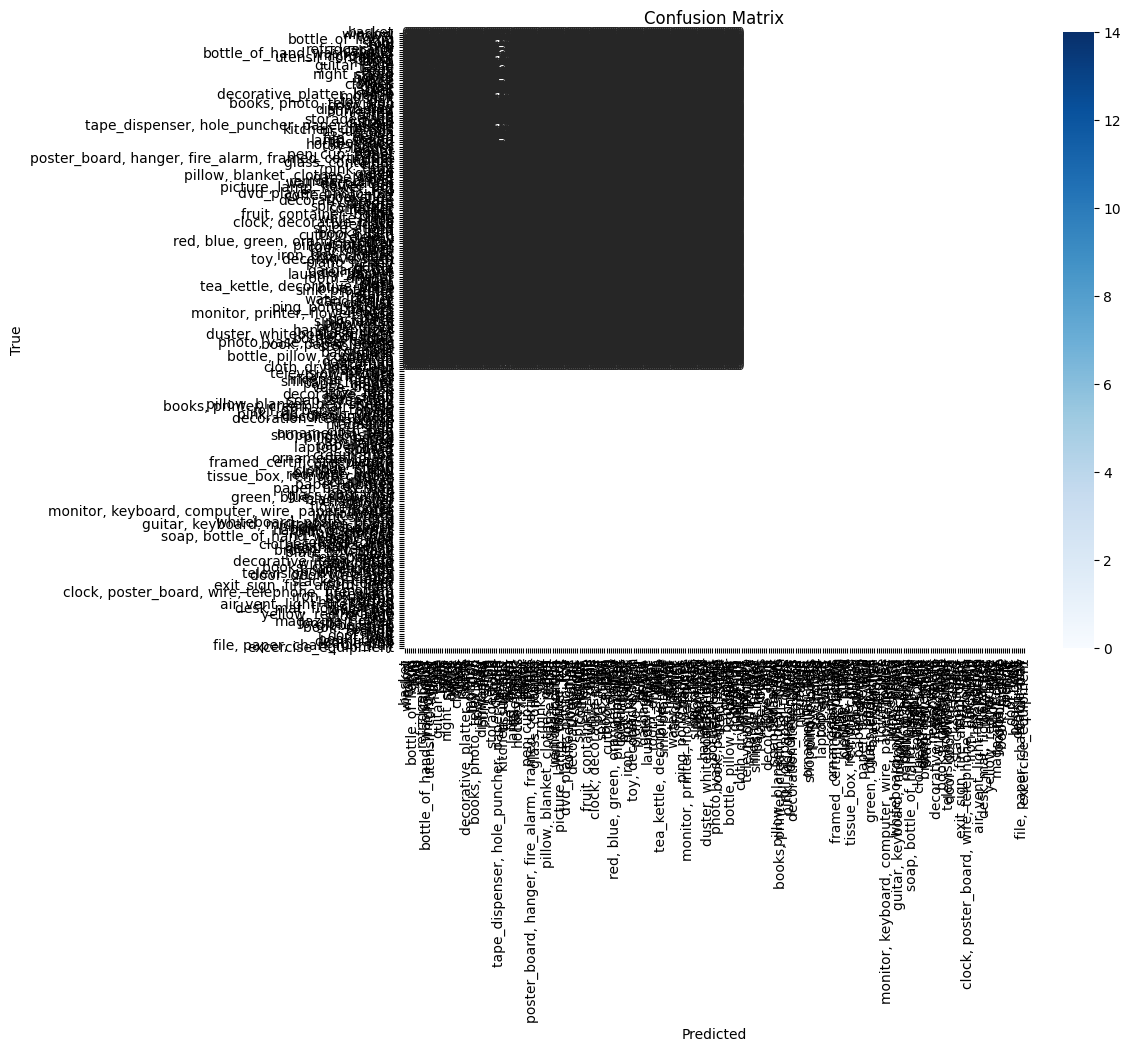

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    eval_preds = []
    eval_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, images, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)
            eval_preds.extend(preds.cpu().numpy())
            eval_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(eval_labels, eval_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_preds, average='weighted')

    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}")

    # Calculate confusion matrix
    cm = confusion_matrix(eval_labels, eval_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Run evaluation
evaluate_model(model, test_dataloader)